<a href="https://colab.research.google.com/github/msrepo/ml-mscise-2023/blob/master/deep_learning/segmentation/Medical_Image_Segmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original notebook by:

Wenjia Bai

RISE-MICCAI Winter School

In this tutorial, you will develop and train a convolutional neural network for brain tumour image segmentation.

In [42]:
# import libraries
import os
import time
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
from torchvision.models.segmentation import fcn_resnet50
import numpy as np
import matplotlib.pyplot as plt
import tarfile
from pathlib import Path
import segmentation_models_pytorch as smp

## Download the imaging dataset

The dataset is curated from the brain imaging dataset in Medical Decathlon Challenge. To save storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each iamge is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [3]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close() 

--2022-11-27 07:57:56--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2022-11-27 07:57:56--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb1bfd9694220912642990f075f.dl.dropboxusercontent.com/cd/0/inline/BxhW-j_J_L3d1FOqAcGj0KDymZfuuWRWGLnqCZnCR5508R6EFKYlgjLiyubV1GYMXabBSHC8KIZ2sT2CqWGW6PtGwvugmvKtJsUKAxXcot5tWlIrtbf8CWSGm9kwHUJmO2M3adoJYIhgxEp1gBKdc_haejZVcJEEJGfiABprAjwf9Q/file# [following]
--2022-11-27 07:57:57--  https://ucb1bfd9694220912642990f075f.dl.dropboxusercontent.com/cd/0/inline/BxhW-j_J_L3d1FOqAcGj0KDymZfuuWRW

**Understand your data**
 

- Visually look at few examples from the dataset. are there errors in the labels? are there repeated examples?
- What is the intensity distribution of images? Do we need to do preprocessing?
- What is the distribution of labels? are they balanced? 
- Do we have any additional metadata available such as gender, location etc.?

In [4]:
sample_img = imageio.imread('/content/Task01_BrainTumour_2D/training_images/BRATS_002_z124.png')
sample_label = imageio.imread('/content/Task01_BrainTumour_2D/training_labels/BRATS_002_z124.png')

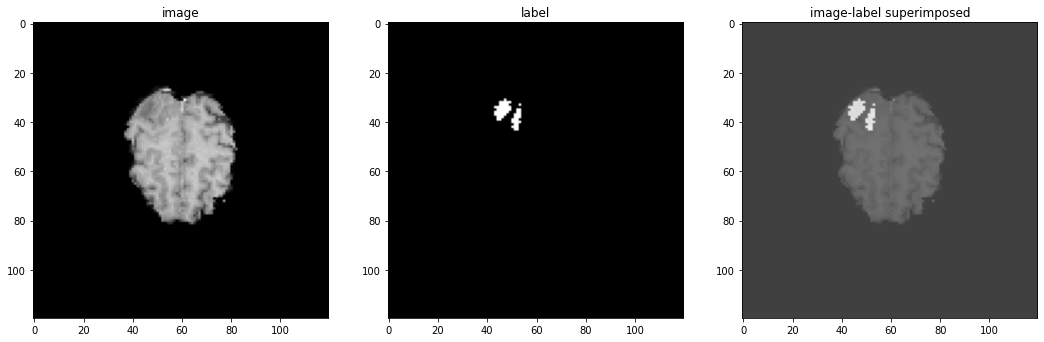

In [5]:
# visualize raw data
%matplotlib inline
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('image')
plt.imshow(sample_img,cmap='gray')
plt.subplot(132)
plt.title('label')
plt.imshow(sample_label,cmap='gray')
plt.subplot(133)
plt.title('image-label superimposed')
plt.imshow(sample_img,cmap='gray',alpha=0.5)
plt.imshow(sample_label,cmap='gray',alpha=0.5)


**How many training and test samples do we have?**


In [6]:
# How many training and test samples do we have?
training_img_paths = Path('/content/Task01_BrainTumour_2D/training_images/').glob('BRATS_*.png')
training_label_paths = Path('/content/Task01_BrainTumour_2D/training_labels/').glob('BRATS_*.png')
test_img_paths = Path('/content/Task01_BrainTumour_2D/test_images/').glob('BRATS_*.png')
test_label_paths = Path('/content/Task01_BrainTumour_2D/test_labels/').glob('BRATS_*.png')
print(f'Training img:{len(list(training_img_paths))} label:{len(list(training_label_paths))} Test img:{len(list(test_img_paths))} label:{len(list(test_label_paths))}')

Training img:2028 label:2028 Test img:730 label:730


**What is the range of intensity values of a sample image and label?**


In [7]:
# What is the range of intensity values of the image?
print(f'Image Intensity Max:{ np.max(sample_img)} Min:{np.min(sample_img)}')
print(f'Label Intensity Min:{np.max(sample_label)} Min:{np.min(sample_label)}')

Image Intensity Max:255 Min:0
Label Intensity Min:1 Min:0


**How many images contain different types of labels?**


In [8]:
label_path = '/content/Task01_BrainTumour_2D/training_labels'
label_names = sorted(os.listdir(label_path))
label_counts ={}
for name in label_names:
  label = imageio.imread(os.path.join(label_path,name))
  unique_labels = np.unique(label)
  for label_key in unique_labels:
    if label_key not in label_counts:
      label_counts[label_key] = 1
    else:
      label_counts[label_key] += 1
print(label_counts)

{0: 2028, 1: 1422, 2: 1007, 3: 899}



Not all the images contain tumour. Edema occurs lot more often that enhancing and non-enhancing tumor.

**What does a typical intensity distribution look like?**


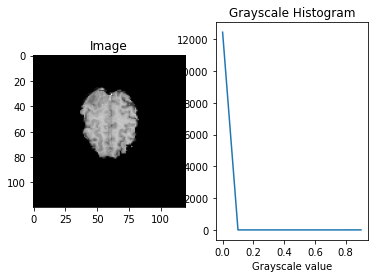

In [9]:
# What does a typical intensity distribution look like?
histogram,bin_edges = np.histogram(sample_img,bins=10,range=(0,1))
plt.figure()
plt.subplot(121)
plt.title('Image')
plt.imshow(sample_img,cmap='gray')
plt.subplot(122)
plt.title('Grayscale Histogram')
plt.xlabel('Grayscale value')
plt.ylabel('pixel count')
plt.plot(bin_edges[0:-1],histogram)
             

**Normalize Input: mean-centered and unit variance**

Originally, the image is in the range (0,1). 

We will preprocess the image so that most of the values lie in the range (-1,1). We will have both positive and negative values as input. This step might be optional.

In [10]:
def normalize_intensity(image,thres_roi=1.0):
  """ Normalize the image intensity by the mean and standard deviation
  
  Parameters:
  thres_roi (float): Use this percentage threshold to calculate 
    mean and std. This allows us to ignore extreme values when 
    mean centering.
  """
  val_l = np.percentile(image,thres_roi)
  roi = (image >= val_l)
  mu, sigma = np.mean(image[roi]),np.std(image[roi])
  eps = 1e-6
  return (image - mu) / (sigma + eps)

Normalized Img Min:-0.3785452715215437 Max:4.338945996235364


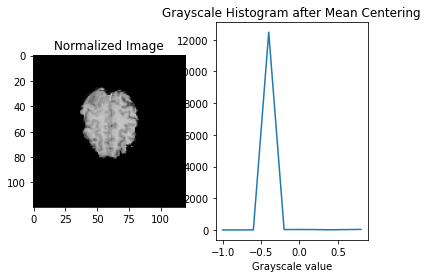

In [11]:
normalized_img = normalize_intensity(sample_img)
print(f'Normalized Img Min:{np.min(normalized_img)} Max:{np.max(normalized_img)}')
histogram,bin_edges = np.histogram(normalized_img,bins=10,range=(-1,1))

plt.figure()
plt.subplot(121)
plt.title('Normalized Image')
plt.imshow(normalized_img,cmap='gray')
plt.subplot(122)
plt.title('Grayscale Histogram after Mean Centering')
plt.xlabel('Grayscale value')
plt.ylabel('pixel count')
plt.plot(bin_edges[0:-1],histogram)

**Train the segmentation model**

Before we start writing code to train the model, Lets write a separate class for processing and feeding data to the training code. This will make the code more readable and modular. This is now a standard practice.Deep Learning frameworks like Pytorch provides utility code for common cases via *Dataset* class. 

In [12]:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class BrainImageSet(Dataset):
  """
  Parameters:
  image_path (str): directory containing images
  label_path (str): directory containing labels

  images (List:np.ndarray): 
  labels (List:np.ndarray):

  For each i-th image, 
  the corresponding label is in the i-th location of *labels* List. 
  """
  def __init__(self, image_path, label_path):
    self.image_path = image_path
    self.images = []
    self.labels = []

    # list of image names, not complete filepath
    image_names = sorted(os.listdir(image_path))
    for name in image_names:
      # Read the image
      image = imageio.imread(os.path.join(image_path,name))
      self.images += [image]

      # Read the label map
      label_name = os.path.join(label_path,name)
      label = imageio.imread(label_name)
      self.labels += [label]

    assert len(self.images) == len(self.labels), f'Number of images{{len(self.images)}} and labels({len(self.labels)}) differ.'

  def __len__(self):
    return len(self.images)
  
  def __getitem__(self,idx):
    # Get an image and perform intensity normalization
    # Dimension: XY
    image = normalize_intensity(self.images[idx])

    # Get its label map
    # Dimension: XY
    label = self.labels[idx]
    return image, label
  
  def get_random_batch(self,batch_size):
    # Get a batch of paired images and label maps
    # Dimension of images: NCXY
    # Dimension of labels: NXY
    images, labels = [], []

    ### Insert your code ###
    idx = np.random.choice(len(self.images),size=batch_size)

    images = [np.expand_dims(self.images[i],axis=0) for i in idx] # add channel
    labels = [self.labels[i] for i in idx] 

    ### End of your code ###

    return np.array(images), np.array(labels)

In [44]:
train_set = BrainImageSet(image_path='/content/Task01_BrainTumour_2D/training_images/',
              label_path='/content/Task01_BrainTumour_2D/training_labels/')
test_set = BrainImageSet(image_path ='/content/Task01_BrainTumour_2D/test_images',
                        label_path = '/content/Task01_BrainTumour_2D/test_labels')

In [14]:

model_dir = 'saved_models'
if not os.path.exists(model_dir):
  os.makedirs(model_dir)


In [26]:
class BaselineSegmentationModel(nn.Module):
  def __init__(self,input_channel=1,output_channel=4,num_filter=16):
    super().__init__()

    # Encoder path
    n = num_filter #16
    self.conv1 = nn.Sequential(
        nn.Conv2d(input_channel,n,kernel_size=3,padding=1),
        nn.BatchNorm2d(n),
        nn.ReLU(),
        nn.Conv2d(n,n,kernel_size=3,padding=1),
        nn.BatchNorm2d(n),
        nn.ReLU()
    )

    n *= 2 #32
    self.conv2 = nn.Sequential(
        nn.Conv2d(int(n/2),n,kernel_size=3,stride=2,padding=1),
        nn.BatchNorm2d(n),
        nn.ReLU(),
        nn.Conv2d(n,n,kernel_size=3,padding=1),
        nn.BatchNorm2d(n),
        nn.ReLU()
    )
    n *= 2  # 64
    self.conv3 = nn.Sequential(
        nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(n),
        nn.ReLU(),
        nn.Conv2d(n, n, kernel_size=3, padding=1),
        nn.BatchNorm2d(n),
        nn.ReLU()
    )

    n *= 2  # 128
    self.conv4 = nn.Sequential(
        nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(n),
        nn.ReLU(),
        nn.Conv2d(n, n, kernel_size=3, padding=1),
        nn.BatchNorm2d(n),
        nn.ReLU()
    )    

    # Decoder path
    n = int(n / 2)  # 64
    self.up3 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.conv_up3 = nn.Sequential(
        nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
        nn.BatchNorm2d(n),
        nn.ReLU(),
        nn.Conv2d(n, n, kernel_size=3, padding=1),
        nn.BatchNorm2d(n),
        nn.ReLU()
    )

    n = int(n / 2)  # 32
    self.up2 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.conv_up2 = nn.Sequential(
        nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
        nn.BatchNorm2d(n),
        nn.ReLU(),
        nn.Conv2d(n, n, kernel_size=3, padding=1),
        nn.BatchNorm2d(n),
        nn.ReLU()
    )

    n = int(n / 2)  # 16
    self.up1 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.conv_up1 = nn.Sequential(
        nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
        nn.BatchNorm2d(n),
        nn.ReLU(),
        nn.Conv2d(n, n, kernel_size=3, padding=1),
        nn.BatchNorm2d(n),
        nn.ReLU()
    )

    # Output
    self.out = nn.Conv2d(n, output_channel, kernel_size=1, padding=0)

  def forward(self, x):
    # Encoder
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.up3(x)
    x = self.up2(x)
    x = self.up1(x)
    x = self.out(x)
    return x

In [27]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# Build the model
num_class = 4
model = BaselineSegmentationModel(input_channel=1,output_channel=4)
model = model.to(device)


Device: cuda


In [28]:
params = list(model.parameters()) # think of these as \theta in the linear model
optimizer = Adam(params,lr=1e-3)
cost_function = nn.CrossEntropyLoss()


**Test the pipeline**

pass the input through the model, evaluate the cost function and see if we get reasonable values.

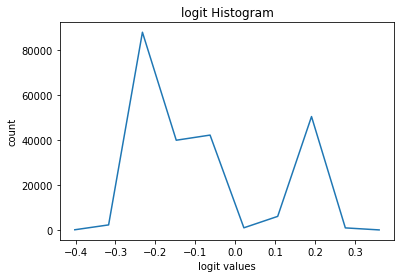

In [29]:

# Get a batch of images and labels
images, labels = train_set.get_random_batch(4)
images, labels = torch.from_numpy(images), torch.from_numpy(labels)
images, labels = images.to(device,dtype=torch.float32), labels.to(device,dtype=torch.long)
logits = model(images) 
# we used cross-entropy loss, so the expected output is
# unnormalized logits for each class

optimizer.zero_grad()
with torch.no_grad():
  plt.title('logit Histogram')
  plt.xlabel('logit values')
  plt.ylabel('count')
  hist,bin_edges = torch.histogram(logits.cpu(),bins=10)
  plt.plot(bin_edges[0:-1],hist)
  

The logits histogram shows that the output of the model is not probabilities (there are negative values in the output) but unnormalized values. This is ok because we use nn.CrossEntropyLoss which normalizes and converts them to probabilities.

If we had used some other loss function, we might have had to transform the logits to probabilities ourselves.

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

**Train the model**

In [ ]:
# Train the model
num_iter = 10000
train_batch_size = 16
start = time.time()
training_iter_loss_history = []
test_iter = []
test_loss_history = []
for i in range(1,1+ num_iter):
  # Set the modules in training mode, which will have effects on certain modules
  start_iter = time.time()
  model.train()
  optimizer.zero_grad()

  # Get a batch of images and labels
  images, labels = train_set.get_random_batch(train_batch_size)
  images, labels = torch.from_numpy(images), torch.from_numpy(labels)
  images, labels = images.to(device,dtype=torch.float32), labels.to(device,dtype=torch.long)
  logits = model(images)


  # Perform optimization
  #### Insert your code ####

  # Forward Propagation: calculate loss
  loss_value = cost_function(logits,labels)
  # Backward Propagation: calculate gradient for each nodes in the computation graph
  loss_value.backward()

  # chnage the weights(learnable parameters) 
  optimizer.step()
  #### End of your code ###

  training_iter_loss_history.append(loss_value.item())
  print(f'--- Iteration {i}: Training loss = {loss_value.item():.4f} Elapsed Time: {time.time() - start_iter:.4f} sec')

  if i % 10 == 0:
    test_iter.append(i)
    model.eval()
    with torch.no_grad():
      images, labels = train_set.get_random_batch(train_batch_size)
      images, labels = torch.from_numpy(images), torch.from_numpy(labels)
      images, labels = images.to(device,dtype=torch.float32), labels.to(device,dtype=torch.long)
      logits = model(images)
      loss_value = cost_function(logits, labels)
    test_loss_history.append(loss_value.item())
  if i % 5000 == 0:
    torch.save(model.state_dict(),os.path.join(model_dir,f'model_{i}.pt'))
print(f'Training took {time.time() - start:.3f} sec')

**Visualize**

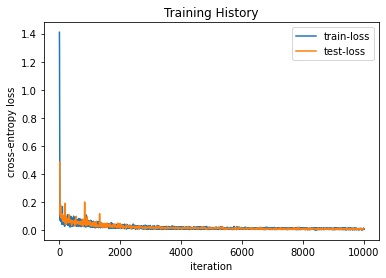

In [41]:
plt.title('Training History')
plt.xlabel('iteration')
plt.ylabel('cross-entropy loss')
plt.plot(training_iter_loss_history,label='train-loss')
plt.plot(test_iter,test_loss_history,label='test-loss')
plt.legend()

In [62]:
MODEL_5000_PATH = '/content/saved_models/model_5000.pt'
MODEL_10000_PATH = '/content/saved_models/model_10000.pt'
model_5k_dict = torch.load(MODEL_5000_PATH)
model_10k_dict = torch.load(MODEL_10000_PATH)

In [79]:
# Get a random batch of test images
# Segment the images using the trained model
VIS_BATCH = 4
images, labels = test_set.get_random_batch(VIS_BATCH)
images, labels = torch.from_numpy(images), torch.from_numpy(labels)
images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
model.eval()

# load untrained model 
model = BaselineSegmentationModel(input_channel=1,output_channel=4)
model.to(device)
logits = model(images)
probabilities = F.softmax(logits, dim=1)
seg_0k = torch.argmax(probabilities,dim=1)


# load model trained till 5000 iteration
model.load_state_dict(model_5k_dict)
logits = model(images)
probabilities = F.softmax(logits, dim=1)
seg_5k = torch.argmax(probabilities,dim=1)


# load model trained till 10000 iteration
model.load_state_dict(model_10k_dict)
logits = model(images)
probabilities = F.softmax(logits, dim=1)
seg_10k = torch.argmax(probabilities,dim=1)

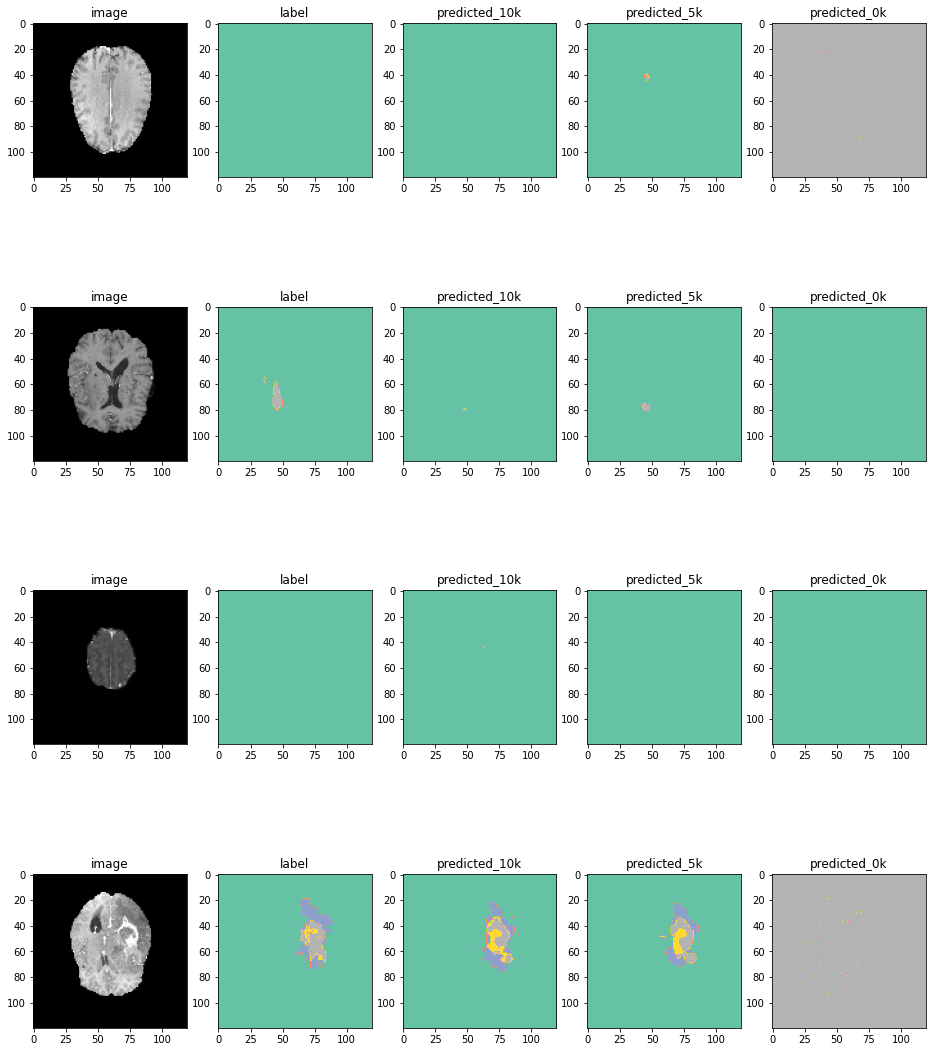

In [95]:
# Visualize the image, predicted segmentation and manual segmentation
NUM_COLS = 5
fig,axs = plt.subplots(VIS_BATCH,NUM_COLS,figsize=(VIS_BATCH*4,NUM_COLS*4))
for i, (im,lb,sg_10k,sg_5k,sg_0k) in enumerate(zip(images,labels,seg_10k,seg_5k,seg_0k)):
  axs[i,0].imshow(im.cpu().numpy().squeeze(),cmap='gray')
  axs[i,0].set_title('image')
  axs[i,1].imshow(lb.cpu(),cmap='Set2')
  axs[i,1].set_title('label')
  axs[i,2].imshow(sg_10k.cpu(),cmap='Set2')
  axs[i,2].set_title('predicted_10k')  
  axs[i,3].imshow(sg_5k.cpu(),cmap='Set2')
  axs[i,3].set_title('predicted_5k')
  axs[i,4].imshow(sg_0k.cpu(),cmap='Set2')
  axs[i,4].set_title('predicted_0k')